# Visualization of tremor catalog with altair

Import Python packages

In [1]:
import altair as alt

# This notebook should be read with Jupyterlab
# Uncomment this line if you opened this file with Jupyter notebook
#alt.renderers.enable('notebook')

import gpdvega
import numpy as np
import pandas as pd

Define functions

In [2]:
def select_tremor(tremors, tbegin, tend, latmin, latmax, lonmin, lonmax):
    """
    Select tremor within user-defined area and time range

    Input:
        type tremors = pandas dataframe
        tremors = {datetime, latitude, longitude, depth}
        type tbegin = datatime.datetime
        tbegin = Beginning of selected time interval
        type tend = datatime.datetime
        tend = End of selected time interval
        type latmin = float
        latmin = Southern boundary of selected region
        type latmax = float
        latmax = Northern boundary of selected region
        type latmin = float
        lonmin = Western boundary of selected region
        type latmin = float
        lonmax = Eastern boundary of selected region
    Output:
        type tremors = pandas dataframe
        tremors = {datetime, latitude, longitude, depth}
    """
    # Keep only tremors within a user-defined area
    if (latmin != None):
        tremors = tremors.loc[(tremors['latitude'] >= latmin)]
    if (latmax != None):
        tremors = tremors.loc[(tremors['latitude'] <= latmax)]
    if (lonmin != None):
        tremors = tremors.loc[(tremors['longitude'] >= lonmin)]
    if (lonmax != None):
        tremors = tremors.loc[(tremors['longitude'] <= lonmax)]
    # Keep only tremors within a user-defined time range
    if (tbegin !=None):
        mask = (tremors['datetime'] >= tbegin)
        tremors = tremors.loc[mask]
    if (tend != None):
        mask = (tremors['datetime'] <= tend)
        tremors = tremors.loc[mask]
    return tremors

In [3]:
def bin_tremor(tremors, nbin, winlen):
    """
    Compute the percentage of the time during which there is recorded tremor

    Input:
        type tremors = pandas dataframe
        tremors = {datetime, latitude, longitude, depth}
        type nbin = integer
        nbin = Duration of the time windows (in minutes) for which we compute
            the percentage of time with tremor
        type winlen = float
        winlen = Duration of the time windows from the tremor catalog
            (in minutes)
    Output:
        type dfInterp = pandas dataframe
        dfInterp = {datetime, latitude, longitude, depth, Time, Value}
    """
    # Bin tremor windows
    smin = str(nbin) + 'T'
    df = pd.DataFrame({'Time': tremors['datetime'], \
                       'Value': np.repeat(1, tremors.shape[0])})
    df.set_index('Time', inplace=True)
    df_group = df.groupby(pd.Grouper(level='Time', freq=smin))['Value'].agg('sum')   
    df_group = df_group.to_frame().reset_index()
    df_group['Value'] = (winlen / nbin) * df_group['Value']
    # Merge datasets to keep the number of tremor windows
    dfInterp = pd.merge_asof(tremors.sort_values(by="datetime"), df_group.sort_values(by="Time"), left_on="datetime", right_on="Time")
    return dfInterp

Set parameters

In [4]:
filename = '../data/tremor.pkl'
winlen = 1.0
nbin =  1440
tbegin = None
tend = None
latmin = None
latmax = None
lonmin = None
lonmax = None

Preprocessing of data

In [5]:
# Read dataset
tremors = pd.read_pickle(filename)[0]
# Select tremors
tremors = select_tremor(tremors, tbegin, tend, latmin, latmax, lonmin, lonmax)
# Construct time line for selection
tremors = bin_tremor(tremors, nbin, winlen)

Selecting a subset of the tremor

In [6]:
subset = tremors.sample(frac=0.1)

Visualize the locations of the tremor source

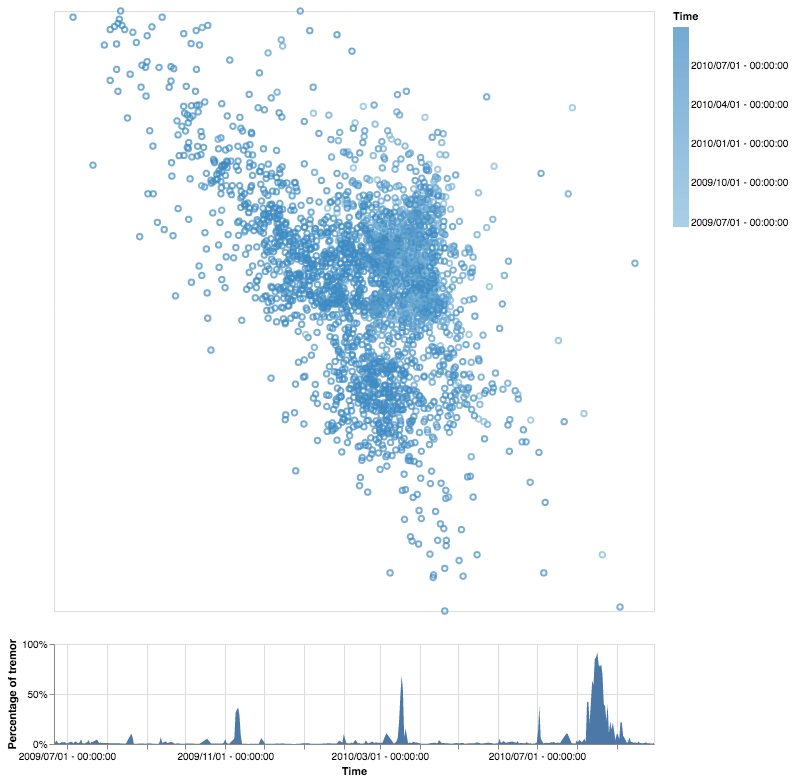

In [7]:
# Selection
brush = alt.selection(type='interval', encodings=['x'])
# Map of tremor location
points = alt.Chart(
).mark_point(
).encode(
    longitude = 'longitude',
    latitude = 'latitude',
    color=alt.Color('Time', legend=alt.Legend(format='%Y/%m/%d - %H:%M:%S'))
).transform_filter(
    brush.ref()
).properties(
    width = 600,
    height = 600
)
# Graph of tremor activity
bars = alt.Chart(
).mark_area(
).encode(
    x = alt.X('Time', axis = alt.Axis(format = '%Y/%m/%d - %H:%M:%S', title = 'Time')),
    y = alt.Y('Value', axis = alt.Axis(format = '%', title = 'Percentage of tremor'))
).properties(
    width = 600,
    height = 100,
    selection = brush
)
# Putting graphs together
myChart = alt.vconcat(points, bars, data = subset)
myChart

To manage big datasets

In [8]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

Visualize all the tremor

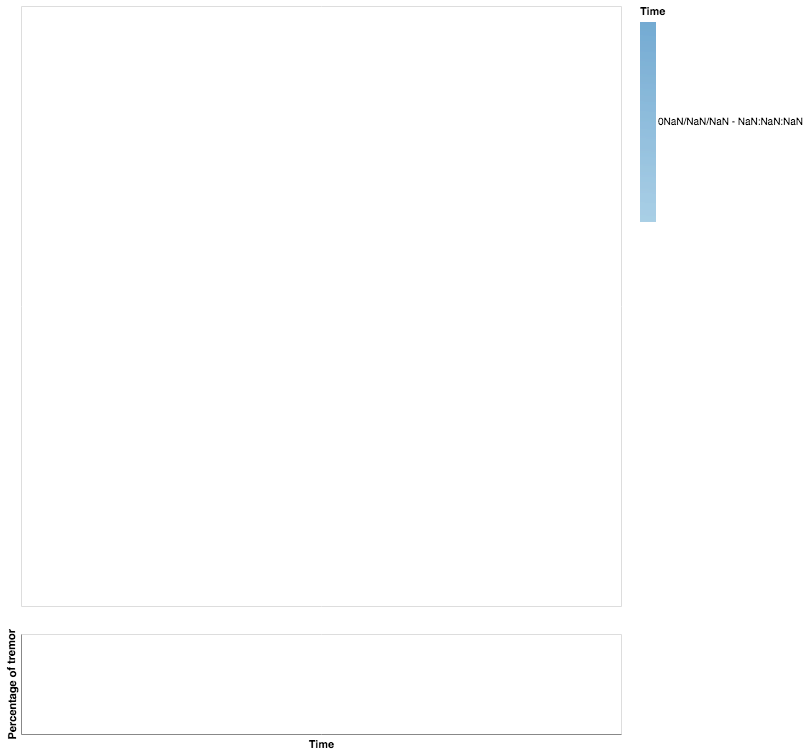

In [9]:
# Selection
brush = alt.selection(type='interval', encodings=['x'])
# Map of tremor location
points = alt.Chart(
).mark_point(
).encode(
    longitude = 'longitude',
    latitude = 'latitude',
    color=alt.Color('Time', legend=alt.Legend(format='%Y/%m/%d - %H:%M:%S'))
).transform_filter(
    brush.ref()
).properties(
    width = 600,
    height = 600
)
# Graph of tremor activity
bars = alt.Chart(
).mark_area(
).encode(
    x = alt.X('Time', axis = alt.Axis(format = '%Y/%m/%d - %H:%M:%S', title = 'Time')),
    y = alt.Y('Value', axis = alt.Axis(format = '%', title = 'Percentage of tremor'))
).properties(
    width = 600,
    height = 100,
    selection = brush
)
# Putting graphs together
myChart = alt.vconcat(points, bars, data = tremors)
myChart

The option to manage big datasets does not seem to work. We should have a look at this.

Things to do:
- Add a background map
- Keep a constant range of latitude and longitude (does not change when we move the slider)
- Improve on the choice of color scale for better visualization effect

How could we do it?
- Read a topojson file as done in https://altair-viz.github.io/gallery/airports_count.html
- How do we find a topojson file for the area we are interested in?